In [12]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


In [13]:
def read_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Function to convert German feature names to English and filter data before 2021
def preprocess_data(df):
    column_name_mapping = {
        "MONATSZAHL": "Category",
        "AUSPRAEGUNG": "Accident-type",
        "JAHR": "Year",
        "MONAT": "Month",
        "WERT": "Value",
        "VORJAHRESWERT": "Previous_Year_Value",
        "VERAEND_VORMONAT_PROZENT": "Change_From_Previous_Month_Percentage",
        "VERAEND_VORJAHRESMONAT_PROZENT": "Change_From_Previous_Year_Month_Percentage",
        "ZWOELF_MONATE_MITTELWERT": "Twelve_Month_Average"
    }
    
    df = df.rename(columns=column_name_mapping)
    df = df[df['Year'] < 2021]
    
    columns_to_exclude = ['Previous_Year_Value', 'Change_From_Previous_Month_Percentage', 
                          'Change_From_Previous_Year_Month_Percentage', 'Twelve_Month_Average']
    
    df = df.drop(columns=[col for col in columns_to_exclude if col in df.columns])
    
    return df

# Function to extract time-related features
def extract_time_related_features(df, month_column='Month'):
    df['Quarter'] = pd.to_datetime(df[month_column], format='%Y%m').dt.quarter
    df['Month_Start_Weekday'] = pd.to_datetime(df[month_column], format='%Y%m').dt.dayofweek + 1
    df['Month_End_Weekday'] = pd.to_datetime(df[month_column], format='%Y%m').apply(
        lambda x: pd.Timestamp(x.year, x.month, x.daysinmonth).dayofweek + 1
    )
    
    return df

def count_groups(df):
    unique_combinations = df.groupby(['Category', 'Accident-type']).size().reset_index().rename(columns={0: 'Count'})
    filters_list = unique_combinations.apply(lambda row: {'Category': row['Category'], 'Accident-type': row['Accident-type']}, axis=1)
    return filters_list



def apply_time_window_features(df, filters):
    def extract_time_window_features(df, month_column, value_column, filters, rolling_functions, rolling_windows, year_windows):
        if filters:
            for key, value in filters.items():
                assert key in df.columns, f"Filter key {key} not in DataFrame."
                df = df[df[key] == value]

        df = df.sort_values(by=month_column).reset_index(drop=True)

        for func_name in rolling_functions:
            for window in rolling_windows:
                col_name = f'{func_name}_{window}m'
                df[col_name] = df[value_column].shift(1).rolling(window=window, min_periods=window).agg(func_name)

        for year_window in year_windows:
            shift_periods = year_window * 12
            lag_col_name = f'value_{year_window}_years_ago'
            df[lag_col_name] = df[value_column].shift(shift_periods)
        return df
    # Predefined rolling functions, windows, and year windows
    rolling_functions = ['mean']
    rolling_windows = [2, 3, 6, 9]  # note if window size is 1, then std is not meaningful
    year_windows = [1]  # note if window size is 1, then std is not meaningful

    # Extracting time window features
    return extract_time_window_features(df, 
                                        'Month', 
                                        'Value', 
                                        filters, 
                                        rolling_functions, 
                                        rolling_windows, 
                                        year_windows)

def count_nan_rows(df):
    return df.isnull().any(axis=1).sum()


def calculate_model_rmse_scores(X, y, models, cv):
    """Calculates and returns RMSE scores for multiple models."""
    model_rmse_scores = {}
    for name, model in models.items():
        rmse_scores = []
        for train_index, test_index in cv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model.fit(X_train, y_train)
            rmse_scores.append(mean_squared_error(y_test, model.predict(X_test), squared=False))
        model_rmse_scores[name] = np.mean(rmse_scores)
    return model_rmse_scores

def plot_actual_vs_predictions(indices, actuals, best_model_predictions, dummy_predictions):
    """Plots actual vs best model and dummy model predictions."""
    plt.figure(figsize=(25, 10))
    plt.plot(indices, actuals, 'o-', color='royalblue', label='Actual Values', linewidth=2, markersize=5)
    plt.plot(indices, best_model_predictions, 'x--', color='limegreen', label='Best Model Predictions', linewidth=2, markersize=7)
    plt.plot(indices, dummy_predictions, 's:', color='darkorange', label='Dummy Predictions', linewidth=2, markersize=7)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.title('Actual vs Best Model and Dummy Model Predictions', fontsize=20)
    plt.xlabel('Index', fontsize=18)
    plt.ylabel('Value', fontsize=18)
    plt.legend(fontsize=16)
    plt.tight_layout()
    plt.show()
def find_and_plot_best_model(df):
    # Initialize models and cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=5)
    models = {
        "LinearRegression": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "RandomForest": RandomForestRegressor(),
        "DummyRegressor": DummyRegressor(strategy='mean')
    }

    # Splitting data
    X, y = df.drop('Value', axis=1), df['Value']

    # Calculate RMSE scores for all models
    model_rmse_scores = calculate_model_rmse_scores(X, y, models, tscv)
    best_model_name = min(model_rmse_scores, key=model_rmse_scores.get)
    best_model = models[best_model_name]
    dummy_model = models["DummyRegressor"]

    # Collect predictions from best and dummy models
    actuals, best_model_preds, dummy_preds, indices = [], [], [], []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        dummy_model.fit(X_train, y_train)
        best_model_preds.extend(best_model.predict(X_test))
        dummy_preds.extend(dummy_model.predict(X_test))
        actuals.extend(y_test)
        indices.extend(test_index)

    # Plot actual vs predictions
    plot_actual_vs_predictions(indices, actuals, best_model_preds, dummy_preds)

    print(f"Model RMSE scores: {model_rmse_scores}")
    print(f"Best Model: {best_model_name} with Average RMSE: {model_rmse_scores[best_model_name]}")

    return best_model



{'Category': 'Alkoholunfälle', 'Accident-type': 'Verletzte und Getötete'}


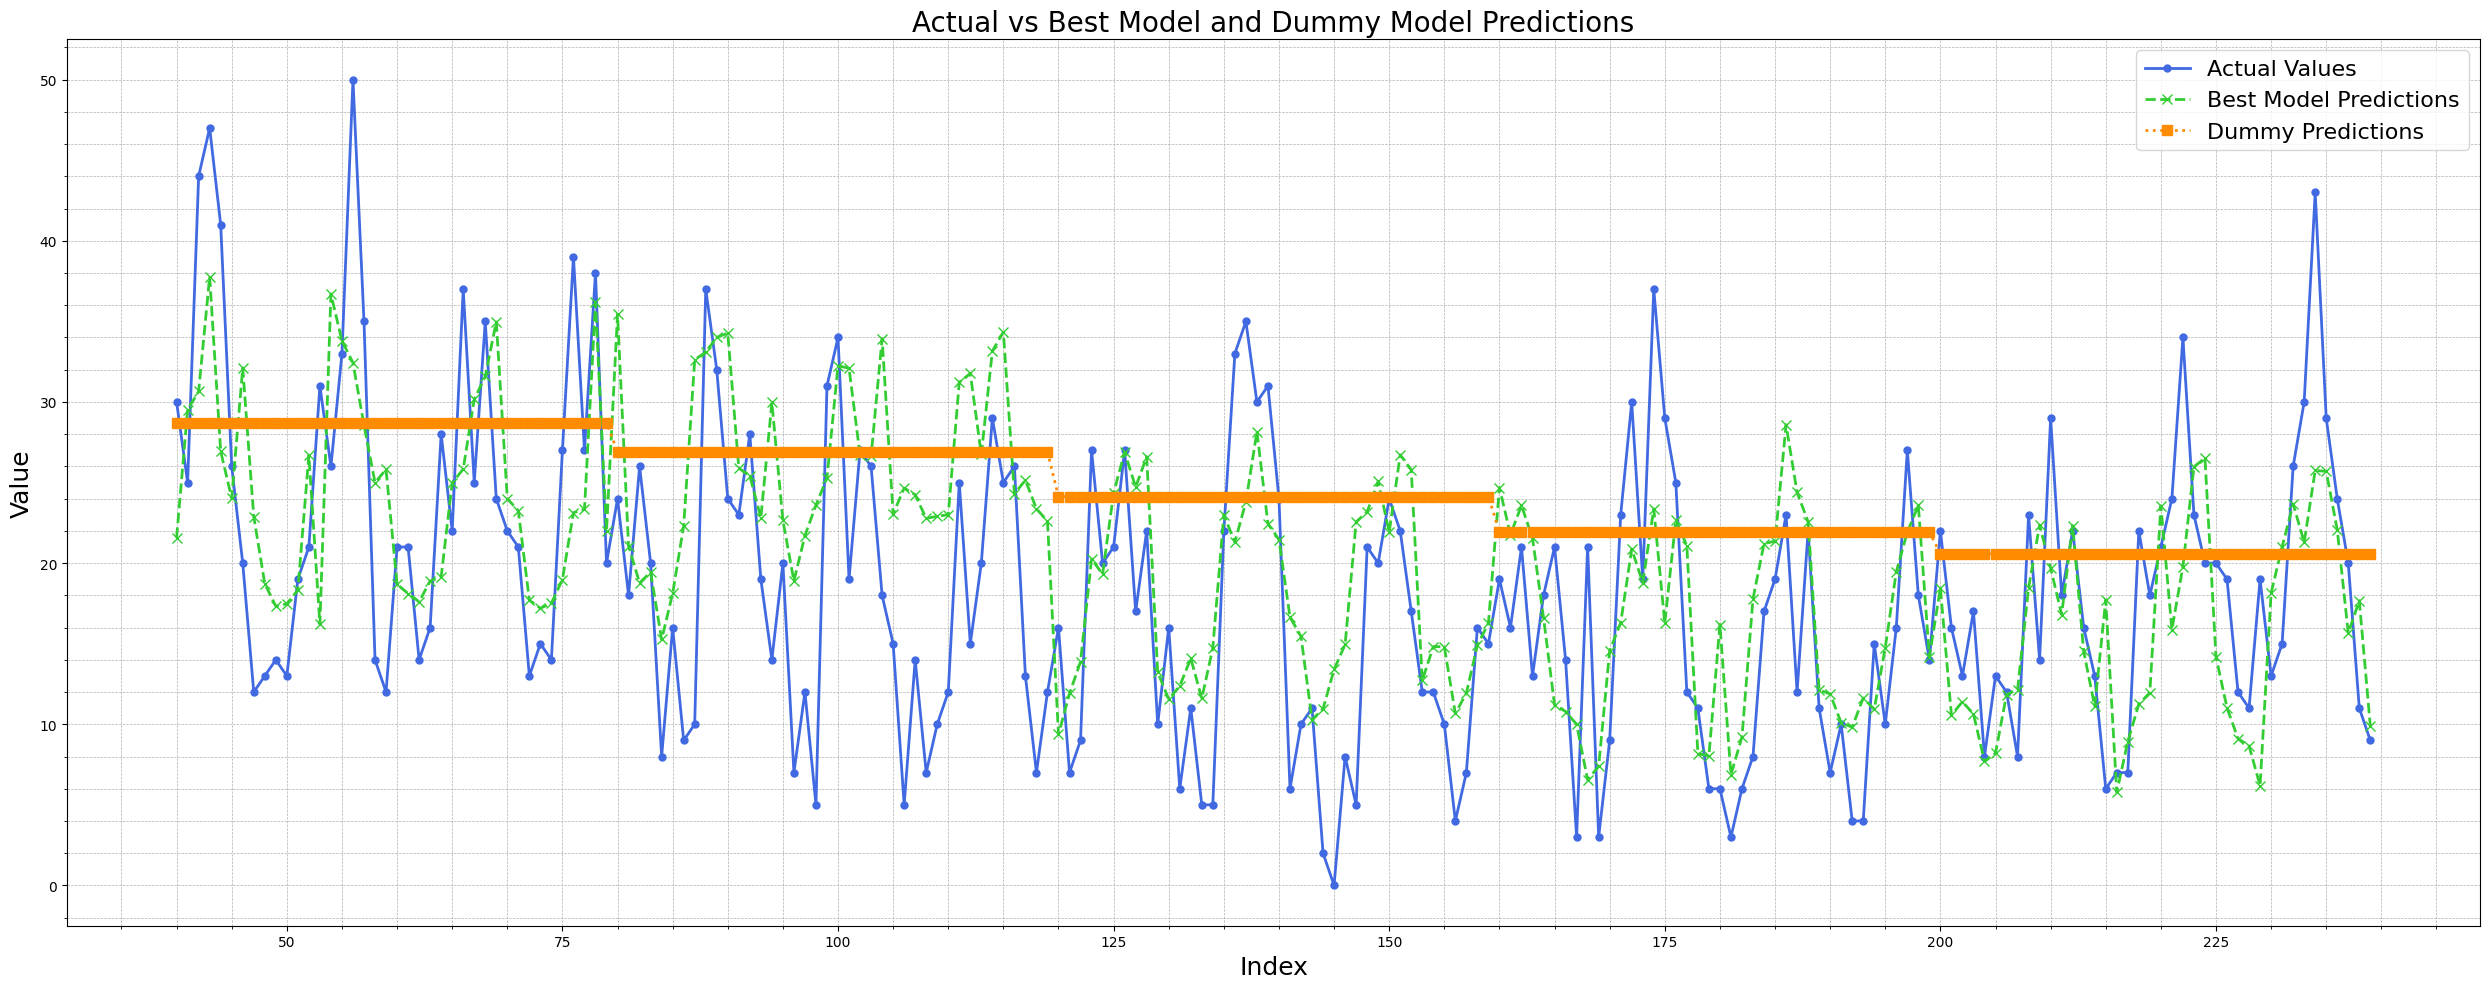

Model RMSE scores: {'LinearRegression': 10.075401238916701, 'Ridge': 9.883475834943107, 'Lasso': 7.947799759451884, 'RandomForest': 7.794232806134758, 'DummyRegressor': 10.844515953776238}
Best Model: RandomForest with Average RMSE: 7.794232806134758
{'Category': 'Alkoholunfälle', 'Accident-type': 'insgesamt'}


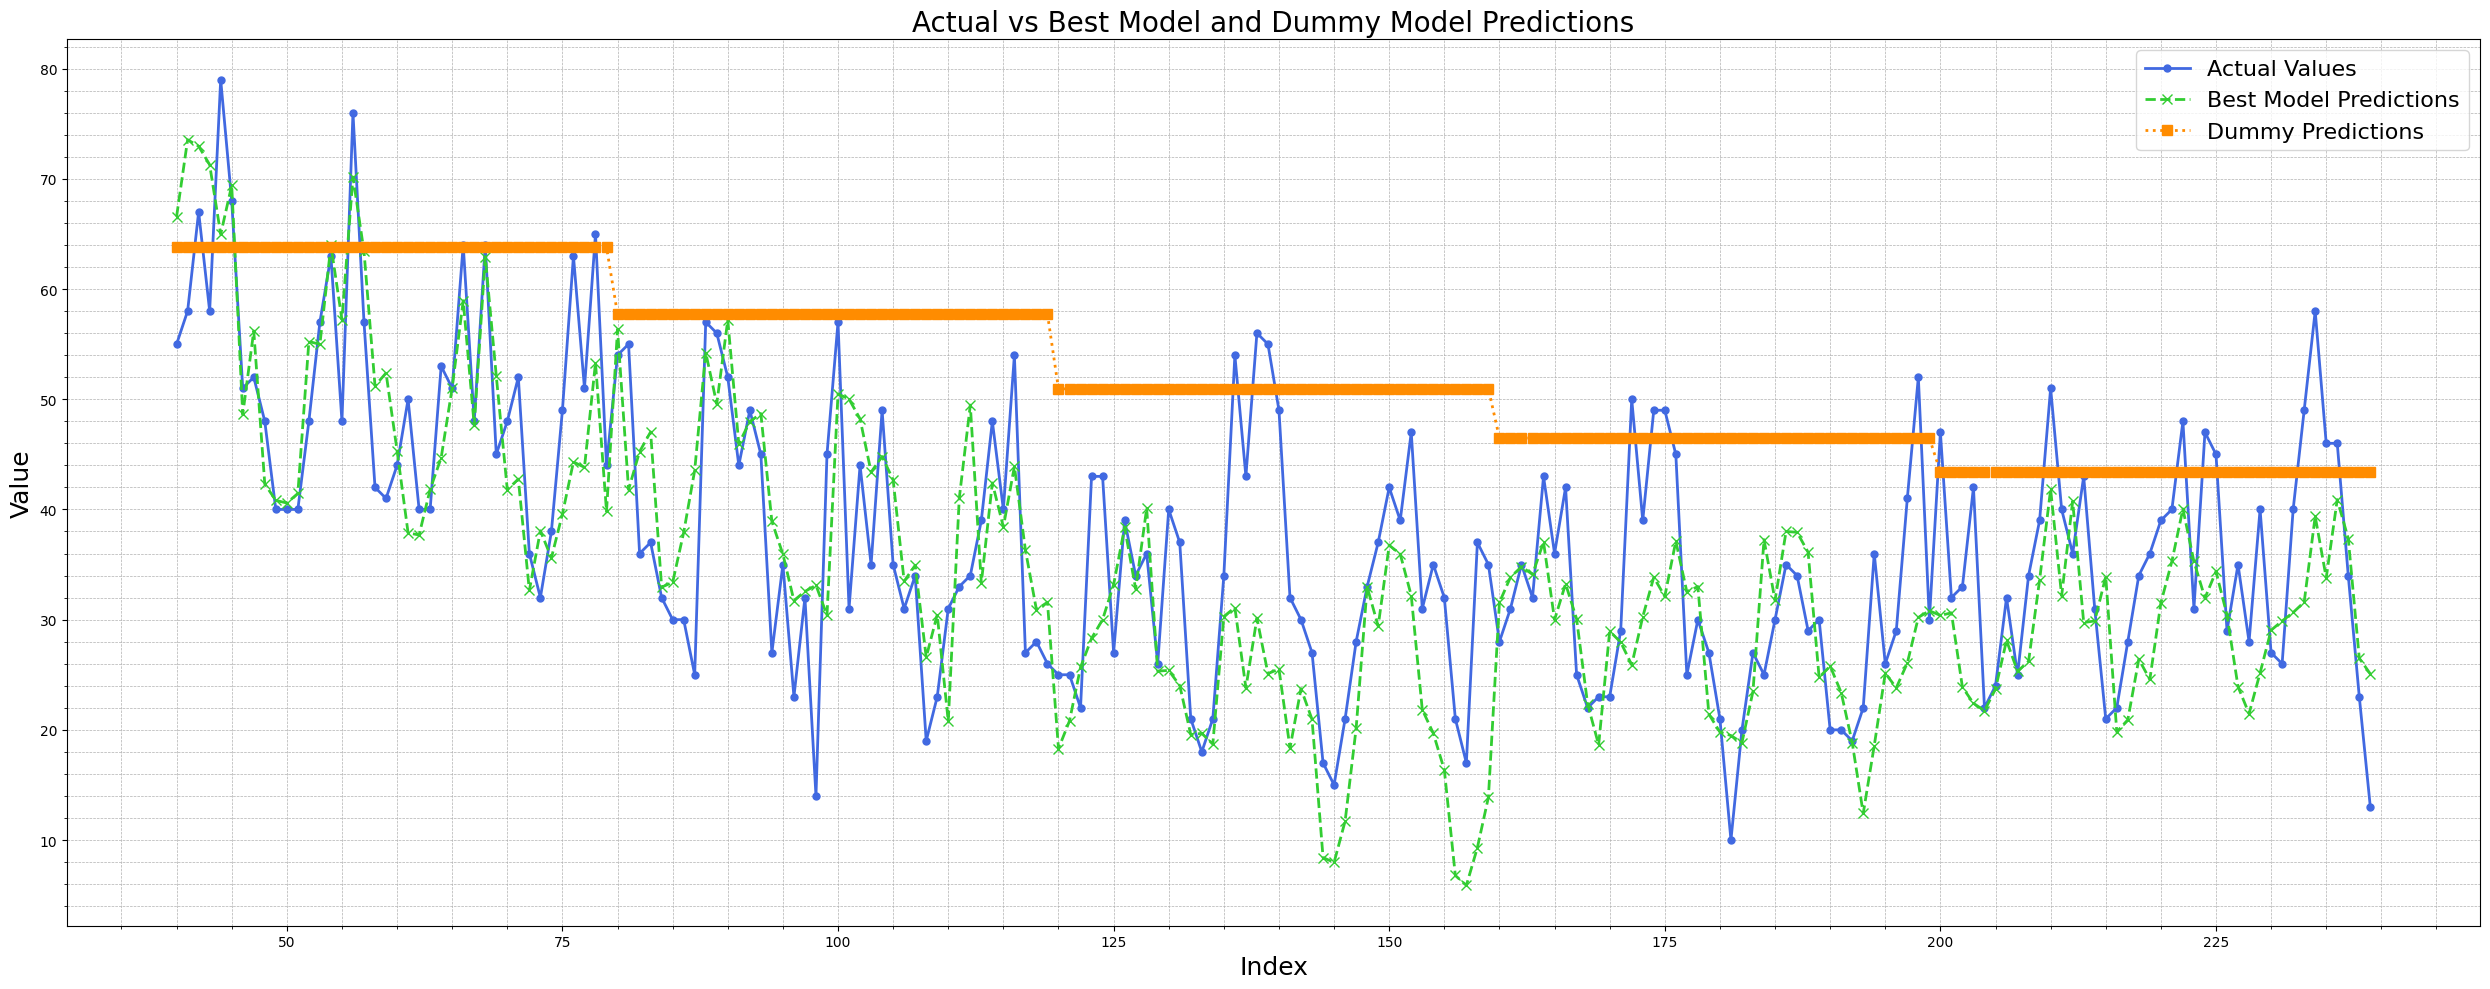

Model RMSE scores: {'LinearRegression': 11.696427229866382, 'Ridge': 11.411866820849488, 'Lasso': 9.584779867873346, 'RandomForest': 10.810248810204191, 'DummyRegressor': 18.206431242958832}
Best Model: Lasso with Average RMSE: 9.584779867873346
{'Category': 'Fluchtunfälle', 'Accident-type': 'Verletzte und Getötete'}


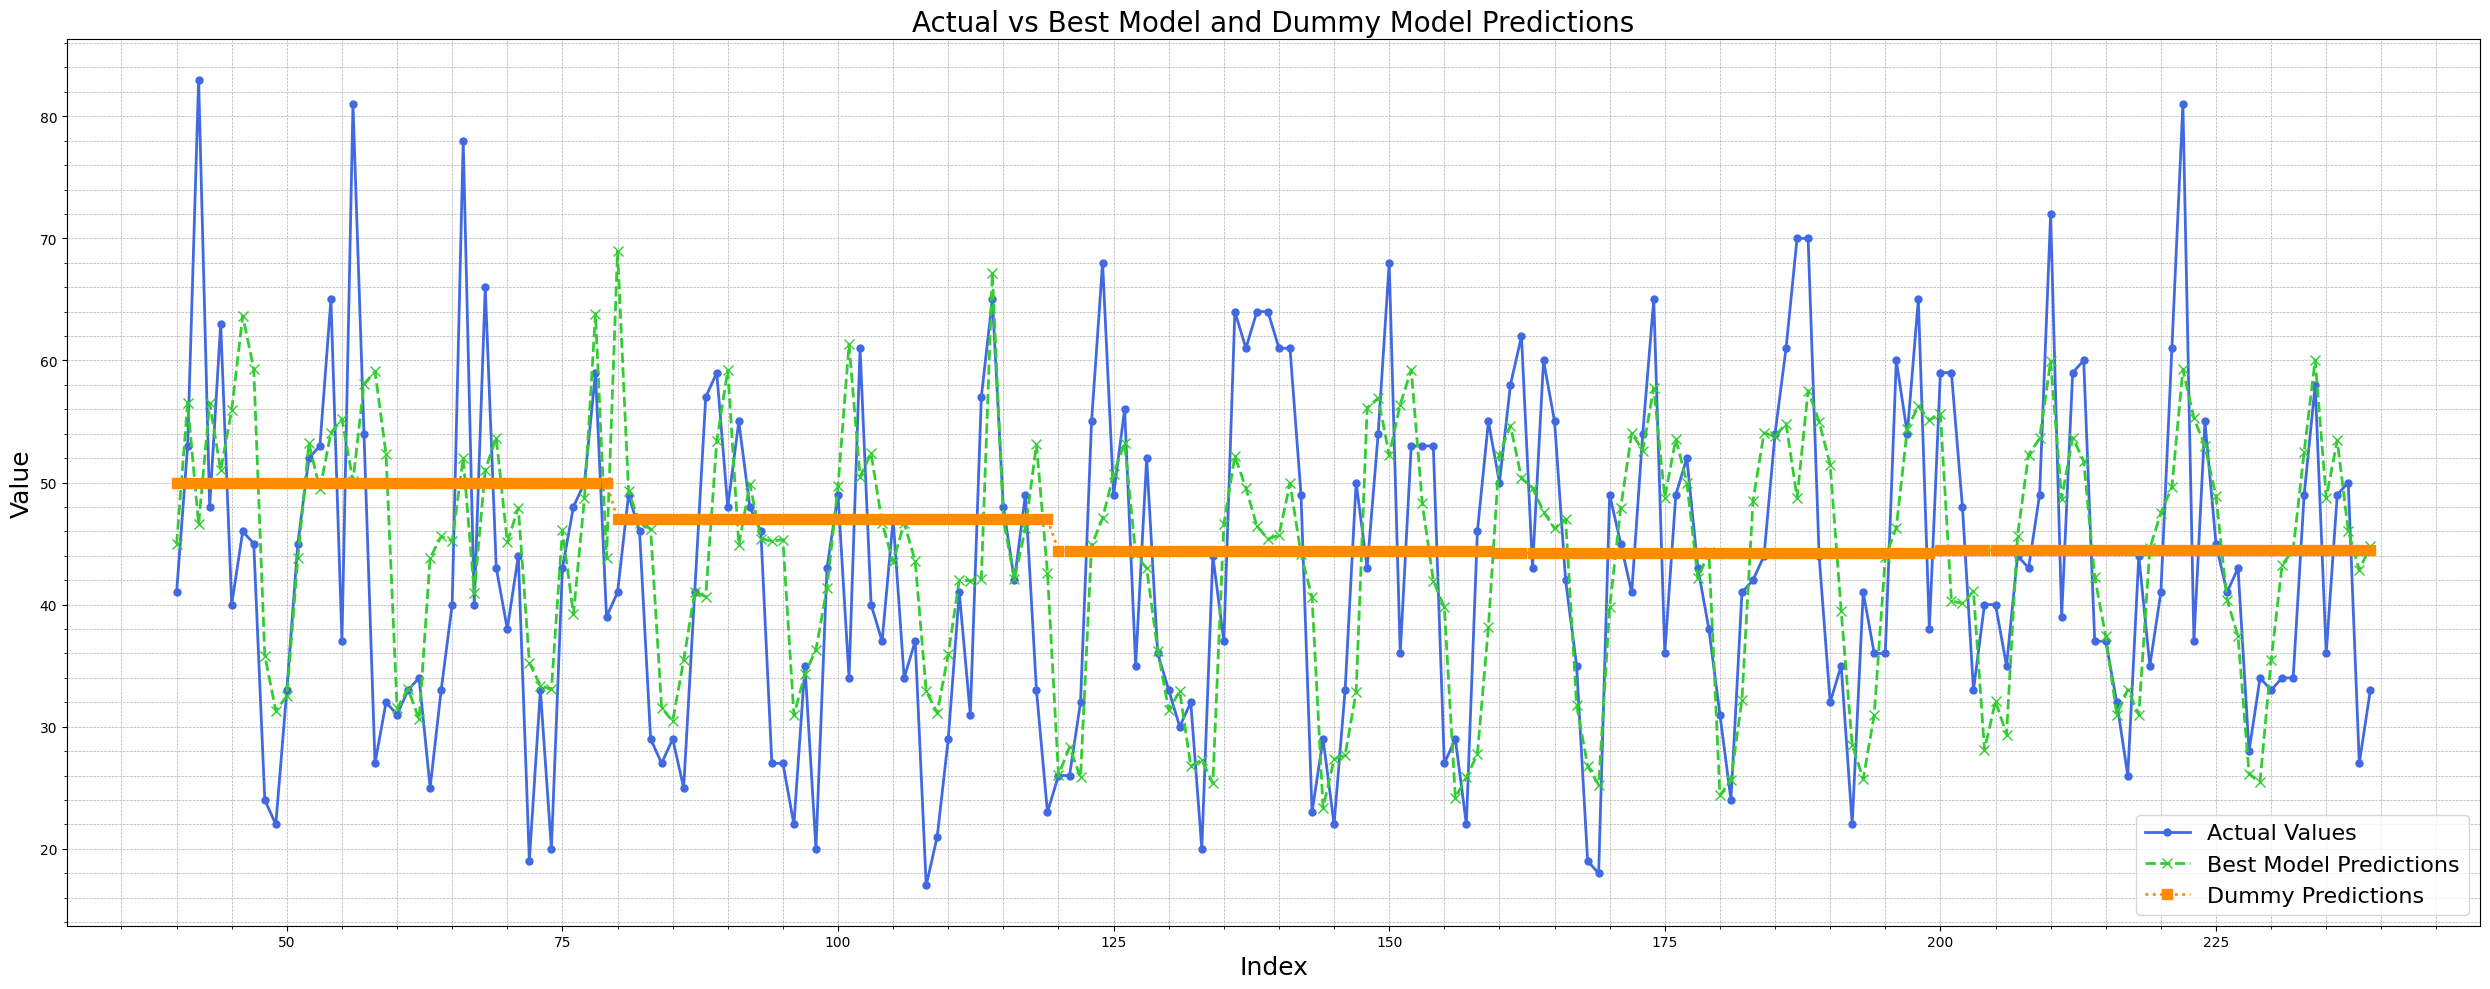

Model RMSE scores: {'LinearRegression': 17.51773152985286, 'Ridge': 17.025591644546033, 'Lasso': 15.138745720274366, 'RandomForest': 10.906527650863879, 'DummyRegressor': 14.25975015365421}
Best Model: RandomForest with Average RMSE: 10.906527650863879
{'Category': 'Fluchtunfälle', 'Accident-type': 'insgesamt'}


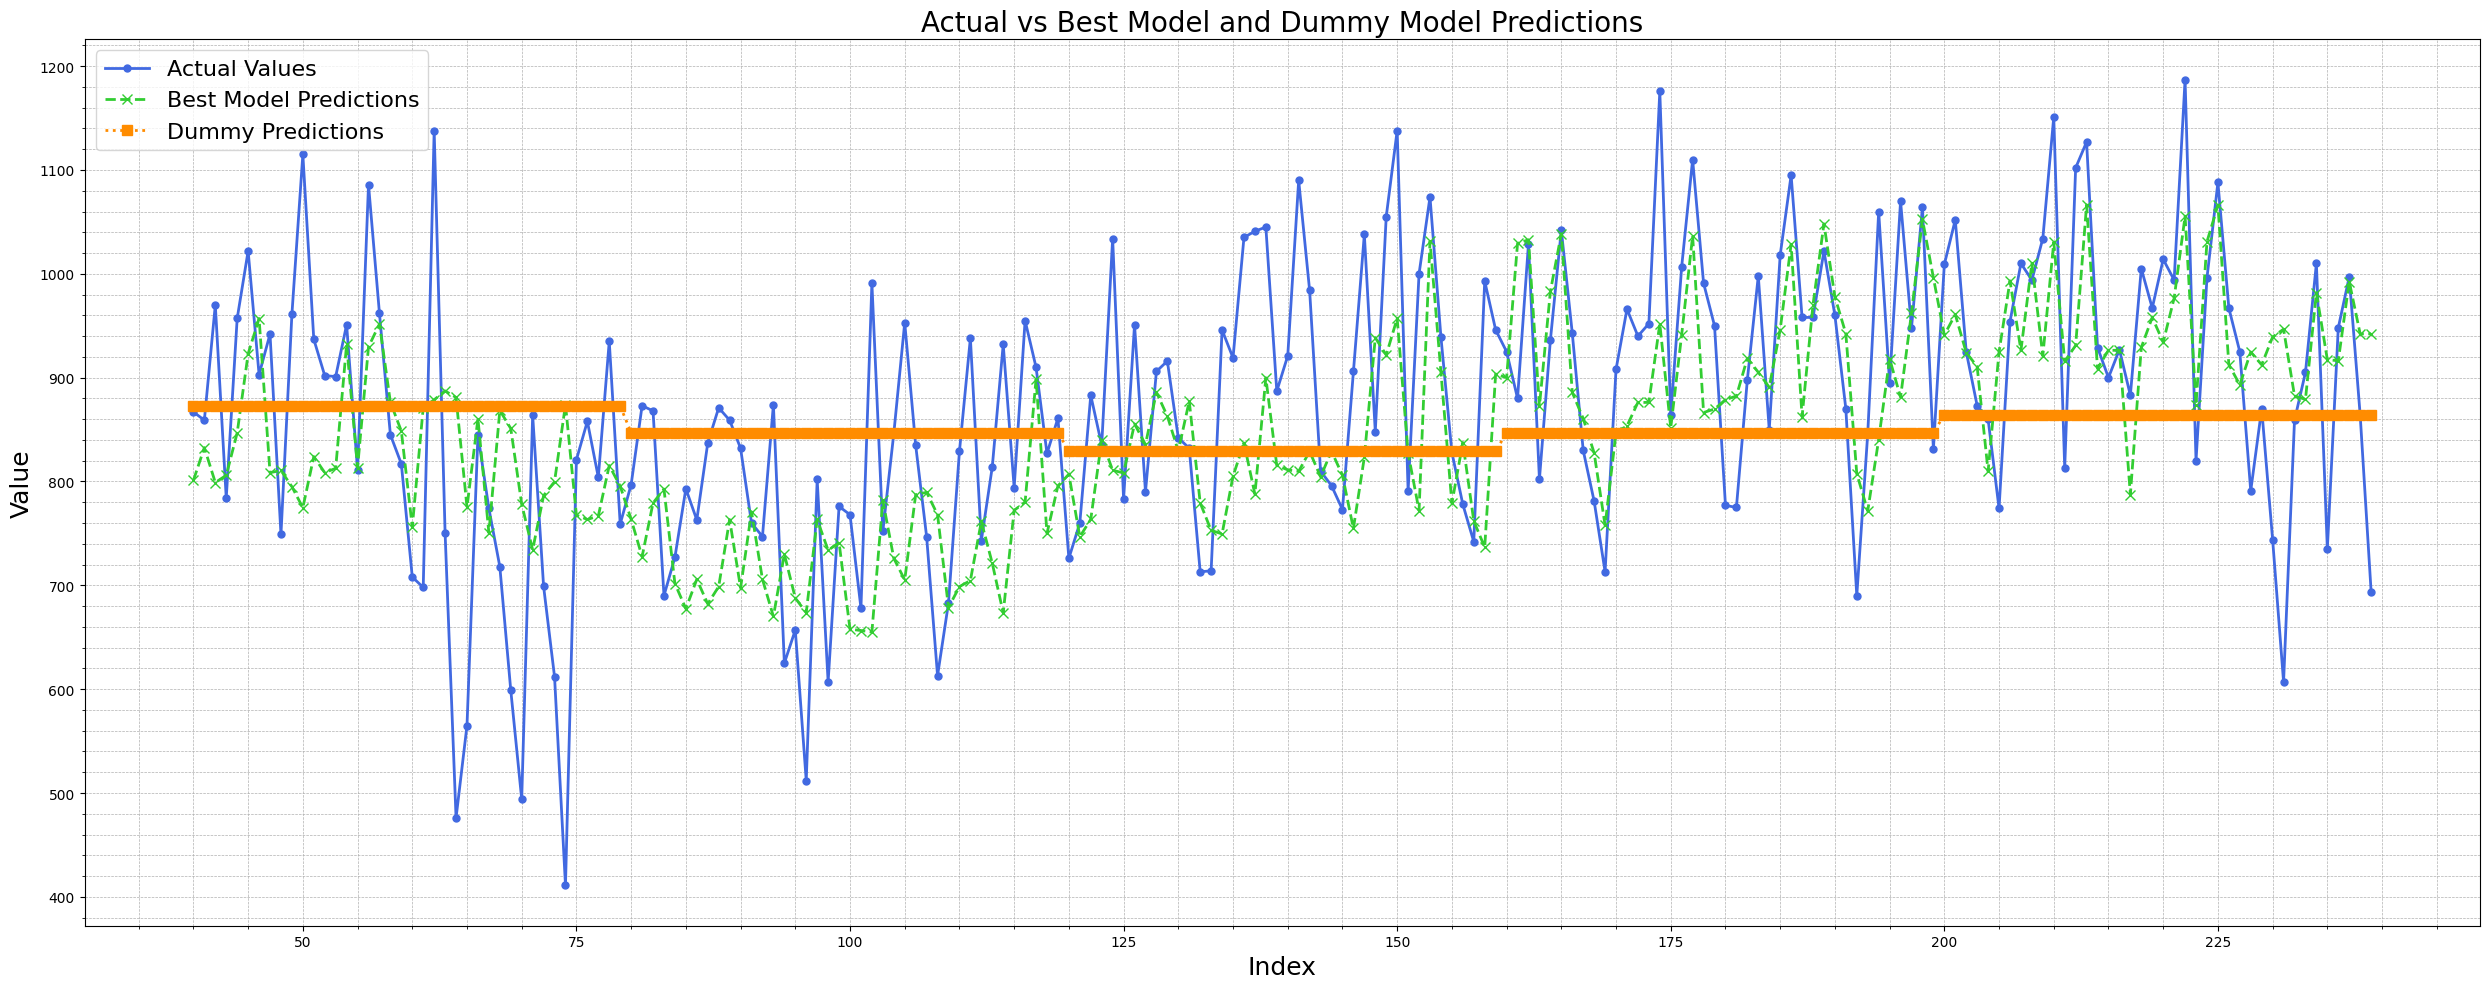

Model RMSE scores: {'LinearRegression': 137.3979120896069, 'Ridge': 134.13779510616004, 'Lasso': 133.84859889023465, 'RandomForest': 122.83401306593548, 'DummyRegressor': 140.977674836612}
Best Model: RandomForest with Average RMSE: 122.83401306593548
{'Category': 'Verkehrsunfälle', 'Accident-type': 'Verletzte und Getötete'}


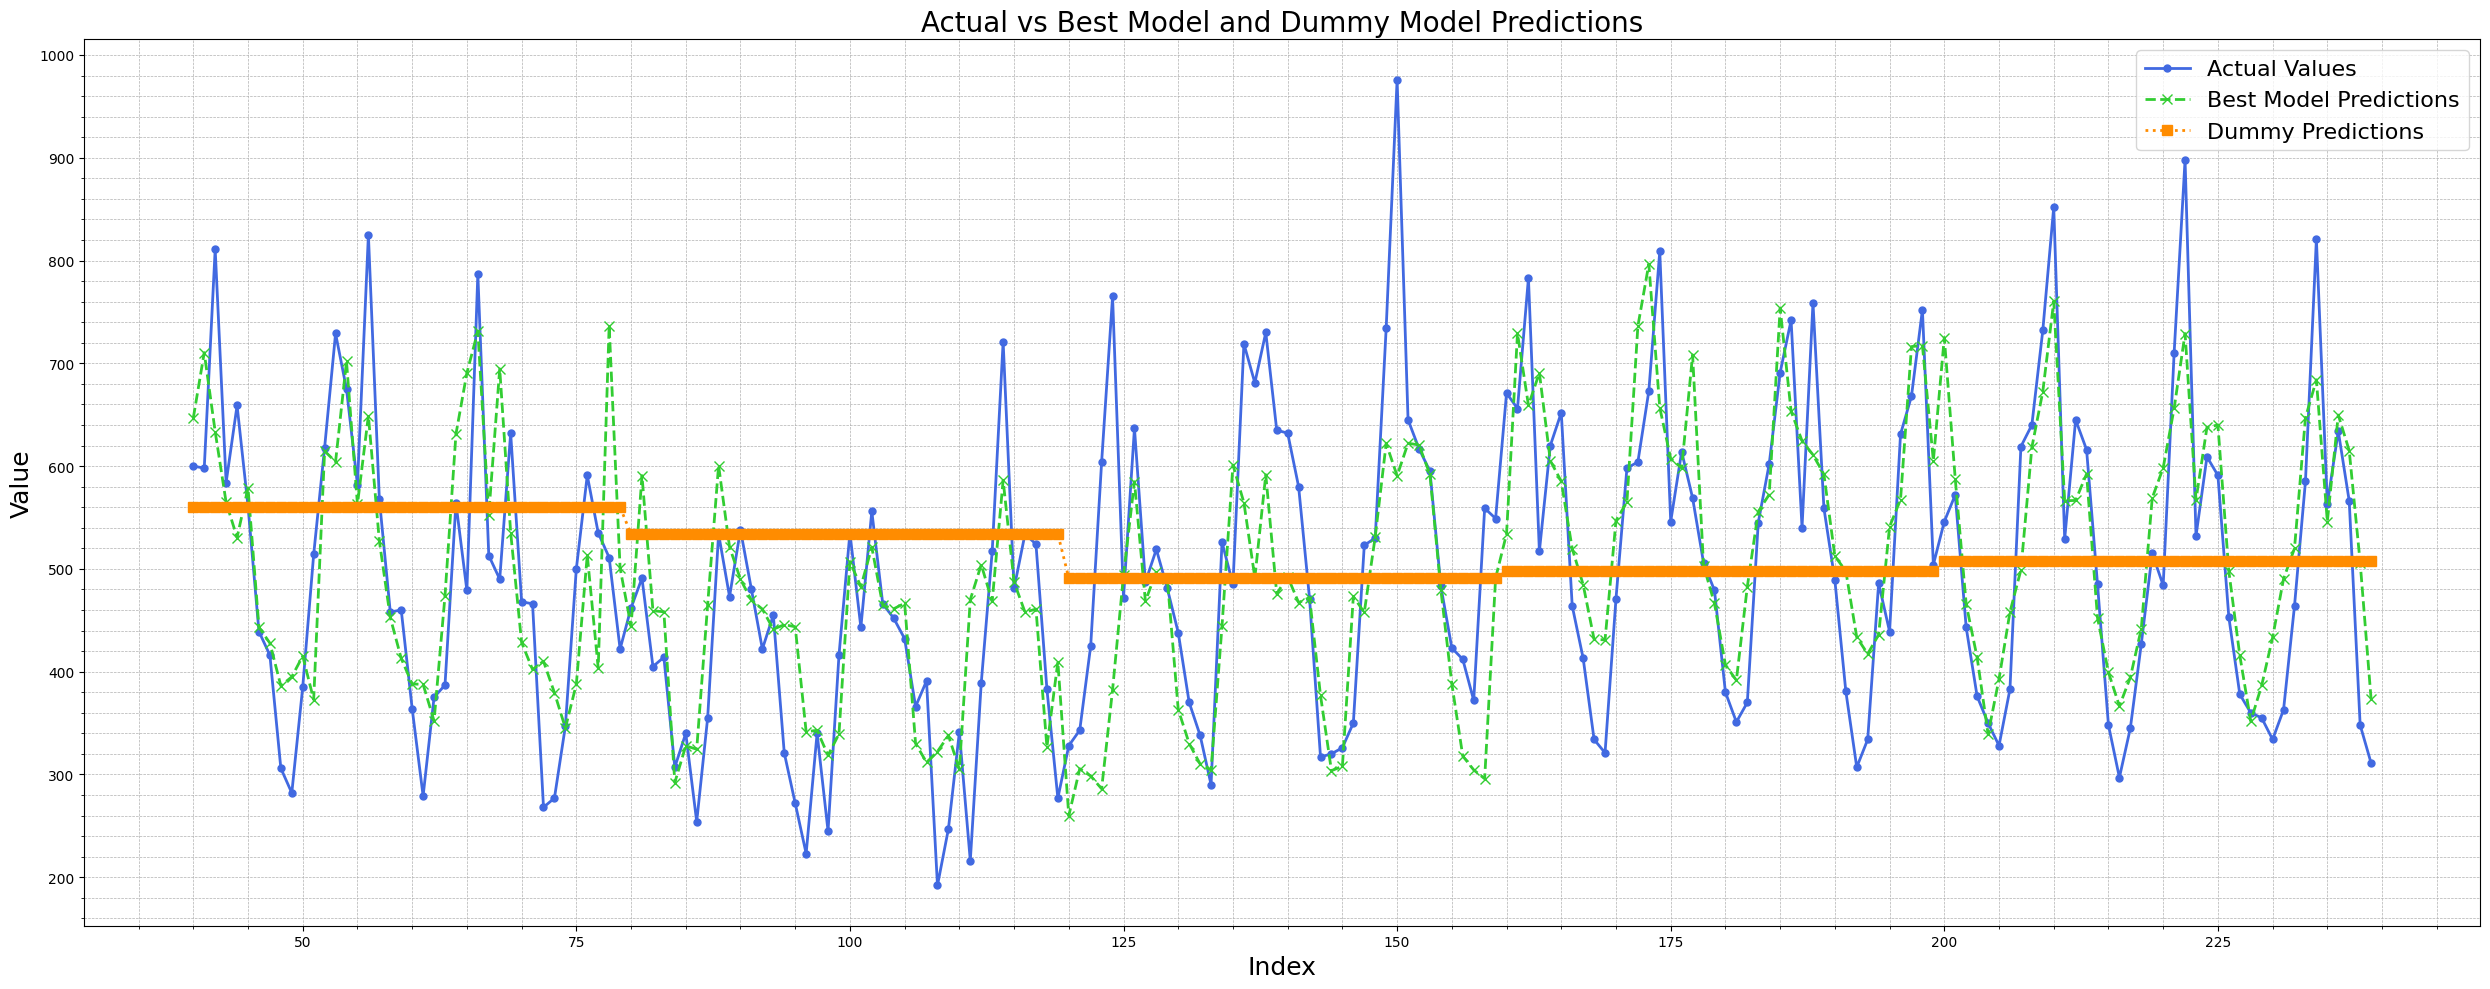

Model RMSE scores: {'LinearRegression': 136.72625896447437, 'Ridge': 134.57071407285744, 'Lasso': 133.33057175851224, 'RandomForest': 96.13830341395304, 'DummyRegressor': 155.05353204221282}
Best Model: RandomForest with Average RMSE: 96.13830341395304
{'Category': 'Verkehrsunfälle', 'Accident-type': 'insgesamt'}


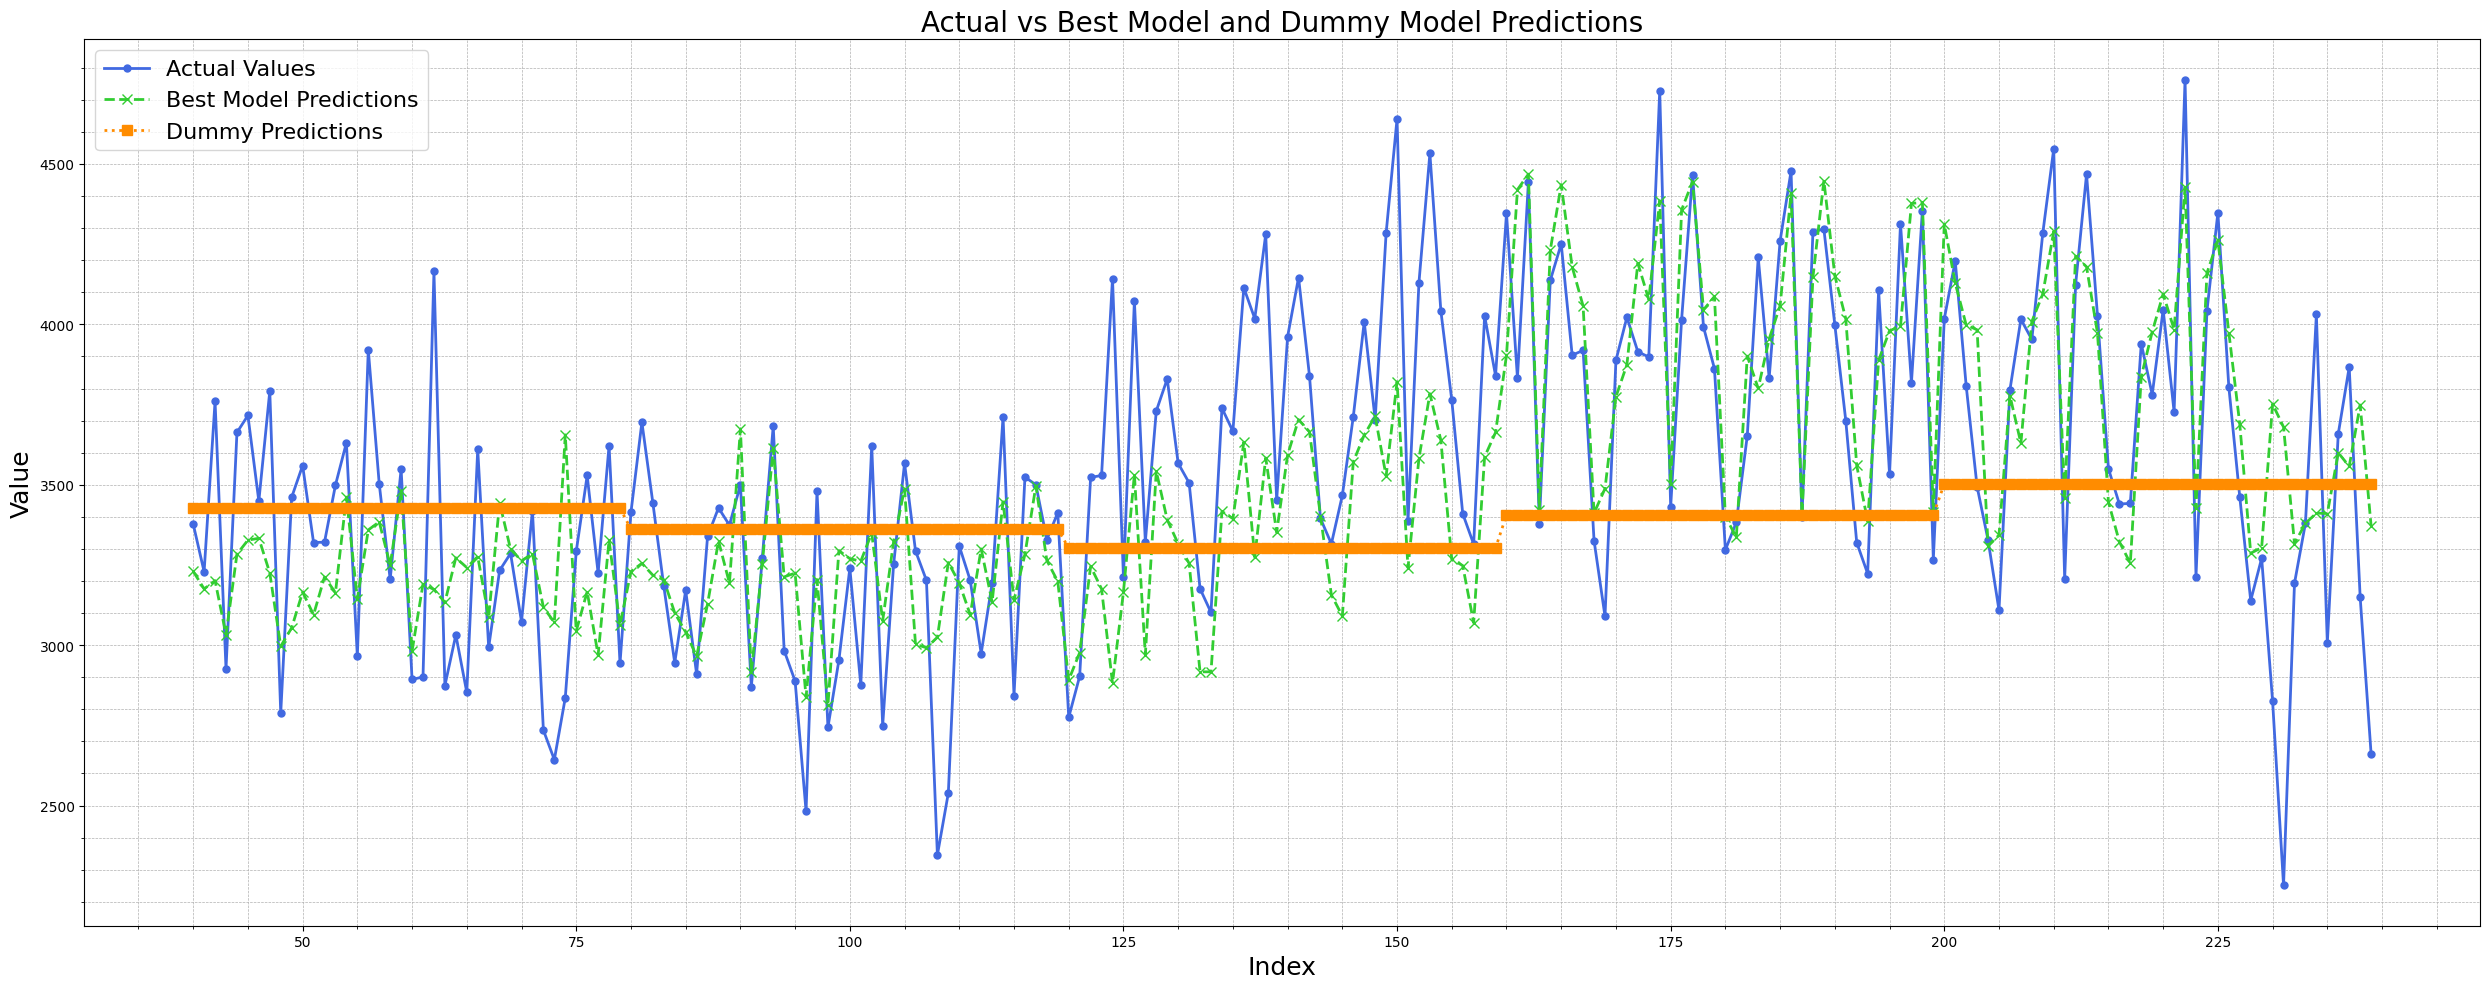

Model RMSE scores: {'LinearRegression': 452.79340095480967, 'Ridge': 438.72747085542187, 'Lasso': 449.29948365987957, 'RandomForest': 333.0068406417207, 'DummyRegressor': 507.1456558218168}
Best Model: RandomForest with Average RMSE: 333.0068406417207
{'Category': 'Verkehrsunfälle', 'Accident-type': 'mit Personenschäden'}


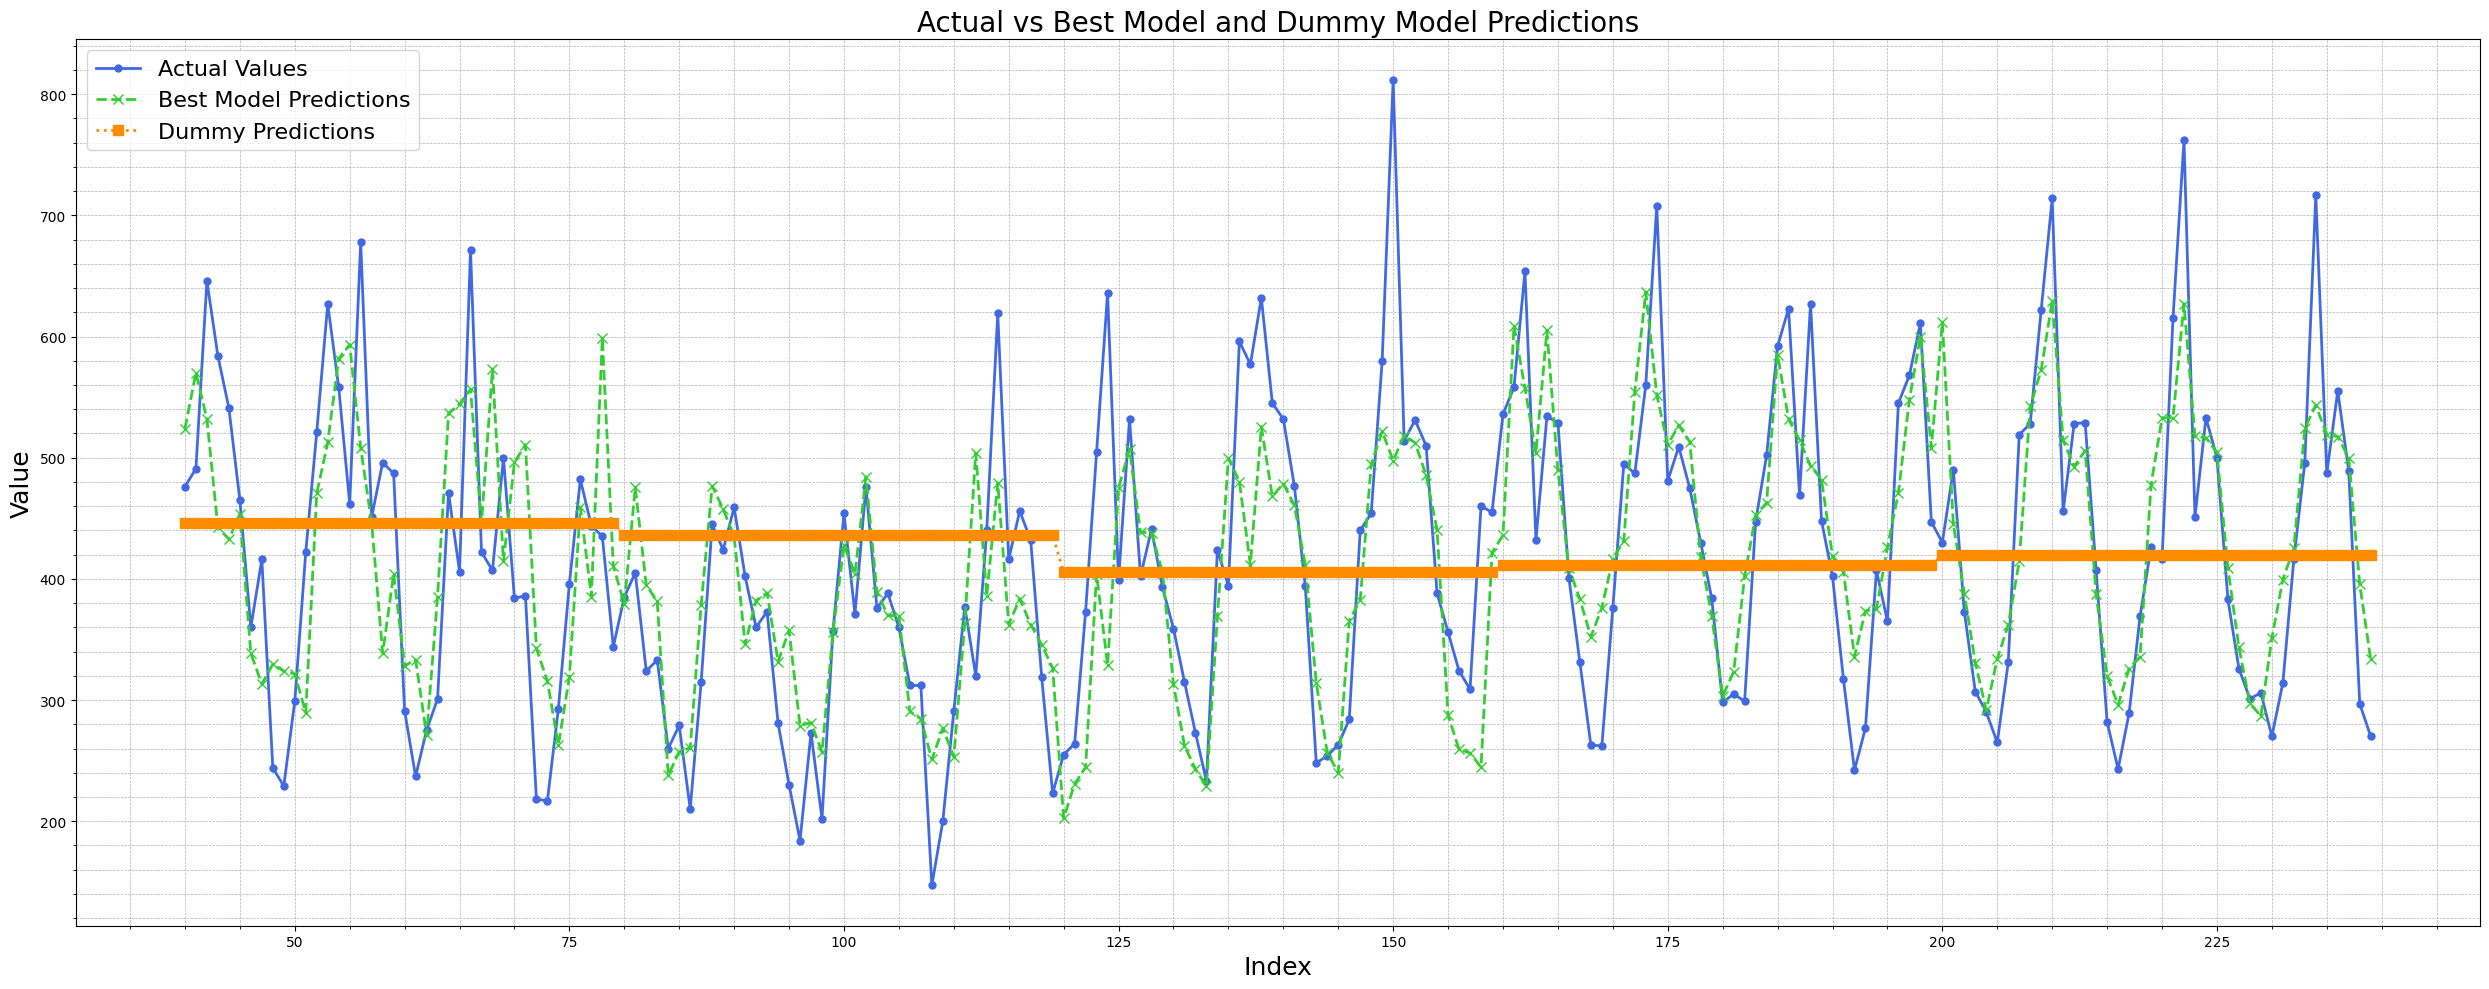

Model RMSE scores: {'LinearRegression': 102.21972027970523, 'Ridge': 100.27388400336048, 'Lasso': 99.47047387109936, 'RandomForest': 79.23365635627641, 'DummyRegressor': 129.58169799677404}
Best Model: RandomForest with Average RMSE: 79.23365635627641


In [14]:
file_path = 'monatszahlen2307_verkehrsunfaelle_10_07_23_nosum.csv'
columns_to_remove=['Category', 'Accident-type', 'Month'] # drop those columns as they are not informative in this case
df = read_data(file_path)
df = preprocess_data(df)
df = extract_time_related_features(df)

group_models = {}


for gp in count_groups(df):
    print(gp)
    df_group = apply_time_window_features(df, {'Category': gp['Category'], 'Accident-type': gp['Accident-type']})
    df_group = df_group.dropna()
    df_group = df_group.drop(columns=columns_to_remove, errors='ignore')

    best_model = find_and_plot_best_model(df_group)

    group_key = str(gp)  # Convert tuple to string if needed
    group_models[group_key] = best_model
    

